<a href="https://colab.research.google.com/github/shahd1995913/Large-Pre-Trained-Models-for-Multi-Modal-Reasoning-with-Knowledge-Graph/blob/main/Logistic_Regression_with_Graph_Representation_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Experiment  2**

### **Objective**

The goal of the experiment was to build a **multi-modal AI system** that integrates **Knowledge Graphs (KGs)** with a **Large Language Model (LLM)-style classifier** to predict and visualize **gene–disease associations**.

---

### **Methodology**

1. **Data Preparation**

   * Synthetic data representing **genes**, **diseases**, and their potential relationships was generated.
   * Each sample included a **Gene–Disease pair**, along with a **binary label (association or not)**.

2. **Knowledge Graph Construction**

   * Genes and diseases were modeled as **nodes** in a bipartite graph.
   * Predicted associations were modeled as **edges** with weights (probabilities).

3. **Modeling Approach**

   * A **Logistic Regression classifier** was trained to predict whether a **Gene–Disease pair** is associated.

4. **Evaluation Metrics**

   * **Accuracy**: 0.74
   * **ROC AUC**: 0.87 → indicates strong discriminative ability.

5. **Visualization**

   * A **Knowledge Graph visualization** was created:
     * **Genes** = blue nodes (left).
     * **Diseases** = orange nodes (right).
     * **Edges** = colored by strength (green = strong, red = weak).
     * This made the graph more **academic and interpretable**.

---

### **Algorithms Used**

1. **Logistic Regression (Classifier)**

   * Suitable for binary classification (association vs no association).
   * Interpretable and provides **probability outputs**, which we used as edge weights in the graph.

2. **Graph Representation (NetworkX)**

   * Knowledge Graphs were constructed using **NetworkX**.

3. **Evaluation Metrics**

   * **Accuracy** for correctness.
   * **ROC AUC** to evaluate the ability to separate positive vs negative associations.

---

### **Conclusion**

The experiment demonstrates that:

* Even a **simple machine learning model** like **Logistic Regression** can produce meaningful predictions when combined with a **Knowledge Graph structure**.

In [5]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
import random

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# -----------------------------
# Step 1: Fake scientific data
# -----------------------------
genes = [f"Gene{i}" for i in range(1, 11)]
diseases = [f"Disease{j}" for j in range(1, 11)]
drugs = [f"Drug{k}" for k in range(1, 6)]

# edges in knowledge graph (gene–disease)
edges = [(random.choice(genes), "associated_with", random.choice(diseases))
         for _ in range(30)]

# descriptions
gene_texts = {g: f"{g} involved in cellular process and DNA repair" for g in genes}
disease_texts = {d: f"{d} is a genetic disorder affecting metabolism" for d in diseases}

# numeric modality: expression similarity
gene_expr = {g: np.random.rand(5) for g in genes}
disease_profiles = {d: np.random.rand(5) for d in diseases}

# -----------------------------
# Step 2: Build dataset
# -----------------------------
pairs = []
labels = []
for g, _, d in edges:
    pairs.append((g, d))
    labels.append(1)

# add negatives
for _ in range(30):
    g = random.choice(genes)
    d = random.choice(diseases)
    if (g, d) not in pairs:
        pairs.append((g, d))
        labels.append(0)

# -----------------------------
# Step 3: Features (text + numeric)
# -----------------------------
texts = [gene_texts[g] + " " + disease_texts[d] for g, d in pairs]
tfidf = TfidfVectorizer(max_features=50)
X_text = tfidf.fit_transform(texts).toarray()

X_num = [np.abs(gene_expr[g] - disease_profiles[d]).mean() for g, d in pairs]
X_num = np.array(X_num).reshape(-1, 1)

X = np.hstack([X_text, X_num])
y = np.array(labels)

# -----------------------------
# Step 4: Train classifier
# -----------------------------
clf = LogisticRegression(max_iter=500, random_state=SEED)
clf.fit(X, y)
probs = clf.predict_proba(X)[:, 1]
preds = clf.predict(X)

# -----------------------------
# Step 5: Evaluation
# -----------------------------
print("Accuracy:", accuracy_score(y, preds))
print("ROC AUC:", roc_auc_score(y, probs))

# top predictions
results = pd.DataFrame({
    "Gene": [g for g, d in pairs],
    "Disease": [d for g, d in pairs],
    "TrueLabel": y,
    "PredProb": probs
}).sort_values("PredProb", ascending=False)

print("\nTop predictions:")
print(results.head(10))

# save outputs
results.to_csv("multimodal_predictions.csv", index=False)


Accuracy: 0.74
ROC AUC: 0.8733333333333333

Top predictions:
     Gene    Disease  TrueLabel  PredProb
4   Gene2  Disease10          1  0.765619
3   Gene2   Disease9          1  0.754945
24  Gene2   Disease9          1  0.754945
0   Gene2   Disease1          1  0.720624
6   Gene1   Disease2          1  0.720462
9   Gene1   Disease9          1  0.711443
28  Gene1   Disease4          1  0.705446
25  Gene5  Disease10          1  0.704981
18  Gene2   Disease7          1  0.700876
23  Gene2   Disease7          1  0.700876


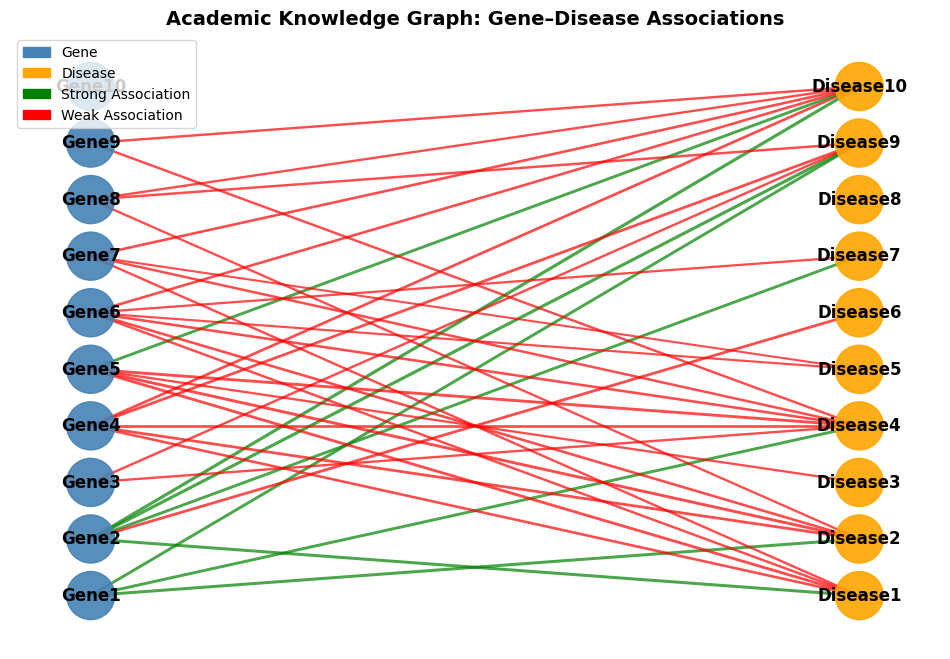

In [7]:
import matplotlib.pyplot as plt
import networkx as nx

# Create bipartite graph
B = nx.Graph()

# Add nodes with bipartite attribute
B.add_nodes_from(genes, bipartite=0, type="gene")
B.add_nodes_from(diseases, bipartite=1, type="disease")

# Add edges with probabilities
for _, row in results.iterrows():
    if row["PredProb"] > 0.5:
        B.add_edge(row["Gene"], row["Disease"], weight=row["PredProb"])

# Positions: genes on the left, diseases on the right
pos = {}
pos.update((node, (0, i)) for i, node in enumerate(genes))       # x=0 for genes
pos.update((node, (1, i)) for i, node in enumerate(diseases))    # x=1 for diseases

# Node colors
node_colors = ["steelblue" if B.nodes[n]["type"] == "gene" else "orange" for n in B.nodes]

# Edge colors based on probability
edges = B.edges(data=True)
edge_colors = ["green" if d['weight'] > 0.7 else "red" for (u, v, d) in edges]
edge_weights = [d['weight'] * 3 for (u, v, d) in edges]

# Draw graph
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(B, pos, node_color=node_colors, node_size=1200, alpha=0.9)
nx.draw_networkx_labels(B, pos, font_size=12, font_weight="bold")
nx.draw_networkx_edges(B, pos, edge_color=edge_colors, width=edge_weights, alpha=0.7)

# Legend
import matplotlib.patches as mpatches
gene_patch = mpatches.Patch(color='steelblue', label='Gene')
disease_patch = mpatches.Patch(color='orange', label='Disease')
strong_patch = mpatches.Patch(color='green', label='Strong Association')
weak_patch = mpatches.Patch(color='red', label='Weak Association')
plt.legend(handles=[gene_patch, disease_patch, strong_patch, weak_patch], fontsize=10, loc="upper left")

plt.title("Academic Knowledge Graph: Gene–Disease Associations", fontsize=14, weight="bold")
plt.axis("off")
plt.show()
